In [1]:
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import random
import requests

In [2]:
url = 'https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+pl_name,hostname,sy_snum,sy_pnum,disc_facility,disc_telescope,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_bmassprov,pl_dens,pl_orbeccen,pl_insol,pl_eqt,pl_orbincl,ttv_flag,pl_imppar,pl_orblper,st_spectype,st_teff,st_mass,st_lum,st_logg,rastr,ra,decstr,dec,sy_dist,sy_vmag,sy_kmag,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2+from+pscomppars&format=csv'
response = requests.get(url)
with open('exoplanets.csv', 'wb') as f:
    f.write(response.content)



1.   pl_name: Exoplanet given name
2.   st_spectype: Host star stellar type (O, B, A, F, G, K, M).
3. st_mass: Stellar Mass (Solar mass)
4. st_teff: Stellar Effective Temperature - K.
5. st_lum: Stellar Luminosity, measured in solar luminosities.
6. sy_snum: Number of stars in the planetary system.
7. sy_pnum: Number of planet in the planetary system.
8. pl_bmasse (pl_mass): Mass of the exoplanet expressed in Earth masses, compared to Earth. (Earth = 1 Me, so 2Me = Earth mass*2).
9. pl_rade: Radius of the explonaet express in Earth radius, compared to Earth. (Earth = 1 Re, so 2Re = Earth radius*2.
10. pl_insol: Average stellar flux at surface express in Earth flux, compared to Earth. ( Earth = 1 Se, 2Se = Earth Se*2)
11. pl_eqt: Exoplanet equilibrium temparature in Kelvins (K), estimated temparature since atmhospheres data uncertain (273.15 Kelvin = 0 Celsius).
12. pl_orbeccen: Planet eccentricity, amount by which the orbit of the planet deviates from a perfect circle.
13. pl_orbper: Orbital period, in days, to complete orbit around stellar host. (Earth = 365 days to complete orbit around Sun).
14. sys_dist: planetary system distance from Earth in parsecs (pc). (1 pc = 3.26 light-years, or 206265 astronomical units, or 30.9 trillion kilometers)
15. grav_acc: gravitational acceleration m/s2

**Classification of Stella Spectra**

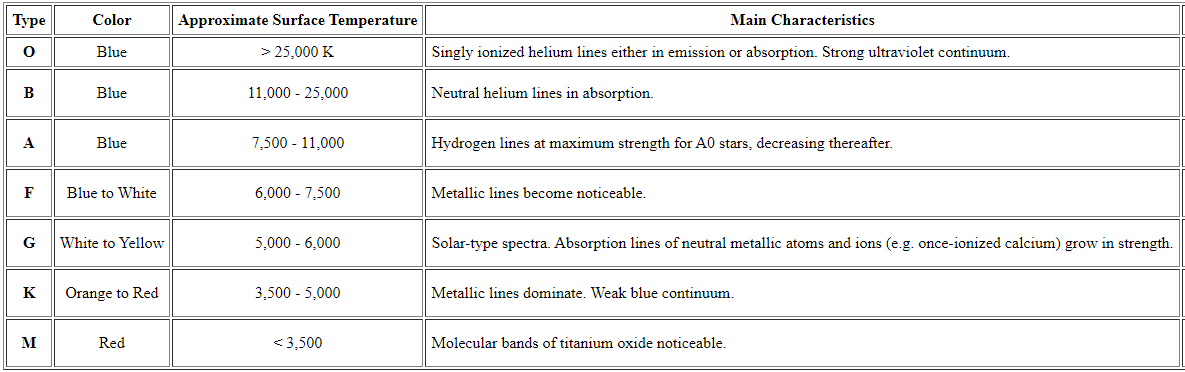

# Methodology
Comparing the exoplanet's feature with Earth's and the solar features.
Including:
- Orbit shape
- Planet density, mass, size, rotational period, revolutional period
- Star temperature (and Stellar Spectra classification)
- Gravitational acceleration


First of all, data cleaning!

In [11]:
# Dataframe
df = pd.read_csv('/content/exoplanets.csv')
df_b = df.copy()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5766 entries, 0 to 5765
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pl_name         5766 non-null   object 
 1   hostname        5766 non-null   object 
 2   sy_snum         5766 non-null   int64  
 3   sy_pnum         5766 non-null   int64  
 4   disc_facility   5766 non-null   object 
 5   disc_telescope  5766 non-null   object 
 6   pl_orbper       5490 non-null   float64
 7   pl_orbsmax      5486 non-null   float64
 8   pl_rade         5745 non-null   float64
 9   pl_radj         5744 non-null   float64
 10  pl_bmasse       5743 non-null   float64
 11  pl_bmassj       5743 non-null   float64
 12  pl_bmassprov    5766 non-null   object 
 13  pl_dens         5661 non-null   float64
 14  pl_orbeccen     4944 non-null   float64
 15  pl_insol        4026 non-null   float64
 16  pl_eqt          4284 non-null   float64
 17  pl_orbincl      4361 non-null   f

In [13]:
nan_values = df.isna() #finds missing values
any_missing_values = nan_values.any().any()
any_missing_values_in_column = nan_values.any()
missing_value_count = df.isnull().sum()

for column, has_missing in any_missing_values_in_column.items():
    if has_missing:
        count = missing_value_count[column]
        print(f"-----> Column '{column}' has {count} missing values.")
#basically checks the dataframe of missing values
print("\nMissing Values in the Entire DataFrame?")
print(any_missing_values)

print("\nMissing Values in Each Column?")
print(any_missing_values_in_column)

print("\nMissing Value Counts in Each Column:")
print(missing_value_count)

-----> Column 'pl_orbper' has 276 missing values.
-----> Column 'pl_orbsmax' has 280 missing values.
-----> Column 'pl_rade' has 21 missing values.
-----> Column 'pl_radj' has 22 missing values.
-----> Column 'pl_bmasse' has 23 missing values.
-----> Column 'pl_bmassj' has 23 missing values.
-----> Column 'pl_dens' has 105 missing values.
-----> Column 'pl_orbeccen' has 822 missing values.
-----> Column 'pl_insol' has 1740 missing values.
-----> Column 'pl_eqt' has 1482 missing values.
-----> Column 'pl_orbincl' has 1405 missing values.
-----> Column 'pl_imppar' has 1597 missing values.
-----> Column 'pl_orblper' has 3979 missing values.
-----> Column 'st_spectype' has 3704 missing values.
-----> Column 'st_teff' has 239 missing values.
-----> Column 'st_mass' has 7 missing values.
-----> Column 'st_lum' has 255 missing values.
-----> Column 'st_logg' has 267 missing values.
-----> Column 'sy_dist' has 25 missing values.
-----> Column 'sy_vmag' has 239 missing values.
-----> Column 'sy

In [14]:
# Gravitational Acceleration Function
# Here is the function to calculate gravitational acceleration
# It will loop through each row to assign the given value

# We will have to convert mass and radius, which are calculated as "xEarth", to standard metrics
# And then apply the gravitational acceleration formula

def calculate_gravitational_acceleration(mass, radius):
    G = 6.67430e-11

    mass_earth_kg = 5.972e24
    radius_earth_m = 6.371e6

    mass_kg = mass * mass_earth_kg
    radius_m = radius * radius_earth_m

    acceleration = (G * mass_kg) / (radius_m ** 2)

    return acceleration

accelerations = []

for index, row in df.iterrows():
    acceleration = calculate_gravitational_acceleration(row["pl_bmasse"], row["pl_rade"])
    accelerations.append(acceleration)

df["grav_acc"] = accelerations
df.head()

,pl_name,hostname,sy_snum,sy_pnum,disc_facility,disc_telescope,pl_orbper,pl_orbsmax,pl_rade,pl_radj,...,ra,decstr,dec,sy_dist,sy_vmag,sy_kmag,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,grav_acc
0,OGLE-2016-BLG-1227L b,OGLE-2016-BLG-1227L,1,1,OGLE,1.3 m Warsaw University Telescope,NaN,3.4000,13.90,1.240,...,265.597125,-33d45m35.2s,-33.759778,NaN,NaN,NaN,NaN,NaN,NaN,12.706347
1,Kepler-276 c,Kepler-276,1,3,Kepler,0.95 m Kepler Telescope,31.884000,0.1994,2.90,0.259,...,293.568197,+39d02m10.72s,39.036312,1144.8600,15.481,13.838,15.3648,0.000421,-0.000421,19.383063
2,Kepler-829 b,Kepler-829,1,1,Kepler,0.95 m Kepler Telescope,6.883376,0.0678,2.11,0.188,...,282.332831,+42d27m49.73s,42.463813,1073.7600,14.973,13.290,14.9206,0.000323,-0.000323,11.249043
3,Kepler-477 b,Kepler-477,2,1,Kepler,0.95 m Kepler Telescope,11.119907,0.0911,2.07,0.185,...,288.067445,+42d21m19.10s,42.355305,367.0000,13.835,11.729,NaN,NaN,NaN,11.321307
4,TOI-1260 c,TOI-1260,1,3,Transiting Exoplanet Survey Satellite (TESS),0.1 m TESS Telescope,7.493134,0.0657,2.76,0.246,...,157.144071,+65d51m15.11s,65.854199,73.5977,11.922,8.950,11.5743,0.000536,-0.000536,17.016337


Orbital Periapsis and Apoapsis
The function calculates two values:

apoapsis: the farthest point of the planet's orbit from the star, calculated as

```
pl_orbsmax * (1 + pl_orbeccen)
```


periapsis: the closest point of the planet's orbit from the star, calculated as
```
pl_orbsmax * (1 - pl_orbeccen)
```
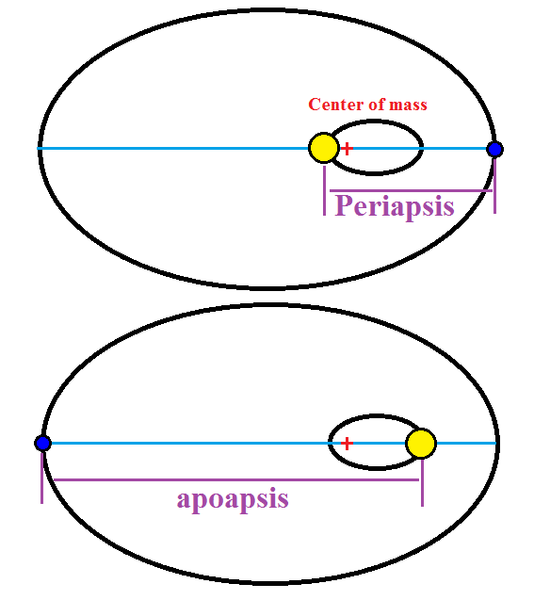

In [15]:
def calculate_orbital_parameters(st_mass, pl_orbsmax, pl_orbeccen):
    apoapsis = pl_orbsmax * (1 + pl_orbeccen)
    periapsis = pl_orbsmax * (1 - pl_orbeccen)
    return apoapsis, periapsis

df["apoapsis_AU"], df["periapsis_AU"] = zip(*df.apply(lambda row: calculate_orbital_parameters(row["st_mass"], row["pl_orbsmax"], row["pl_orbeccen"]), axis=1))
df.head() #dont forget to put it to the df again!

,pl_name,hostname,sy_snum,sy_pnum,disc_facility,disc_telescope,pl_orbper,pl_orbsmax,pl_rade,pl_radj,...,dec,sy_dist,sy_vmag,sy_kmag,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,grav_acc,apoapsis_AU,periapsis_AU
0,OGLE-2016-BLG-1227L b,OGLE-2016-BLG-1227L,1,1,OGLE,1.3 m Warsaw University Telescope,NaN,3.4000,13.90,1.240,...,-33.759778,NaN,NaN,NaN,NaN,NaN,NaN,12.706347,NaN,NaN
1,Kepler-276 c,Kepler-276,1,3,Kepler,0.95 m Kepler Telescope,31.884000,0.1994,2.90,0.259,...,39.036312,1144.8600,15.481,13.838,15.3648,0.000421,-0.000421,19.383063,0.1994,0.1994
2,Kepler-829 b,Kepler-829,1,1,Kepler,0.95 m Kepler Telescope,6.883376,0.0678,2.11,0.188,...,42.463813,1073.7600,14.973,13.290,14.9206,0.000323,-0.000323,11.249043,0.0678,0.0678
3,Kepler-477 b,Kepler-477,2,1,Kepler,0.95 m Kepler Telescope,11.119907,0.0911,2.07,0.185,...,42.355305,367.0000,13.835,11.729,NaN,NaN,NaN,11.321307,0.0911,0.0911
4,TOI-1260 c,TOI-1260,1,3,Transiting Exoplanet Survey Satellite (TESS),0.1 m TESS Telescope,7.493134,0.0657,2.76,0.246,...,65.854199,73.5977,11.922,8.950,11.5743,0.000536,-0.000536,17.016337,0.0657,0.0657


In [16]:
# Here I am creating a new column for each of those features
# The new column will be named [column]+"_php"
# It will return True or False if conditions are met or not

# Considering that the values in the dataset are not perfectly exacts,
# I have purposely increase a little bit 'pl_eqt' and 'pl_orbeccen' ranges,
# To preserve potential candidates

def check_conditions(df):
# Most likely conditions for an exoplanet to be life-friendly
    conditions = {
        "pl_bmasse": (0.1 < df["pl_bmasse"]) & (df["pl_bmasse"] < 10), # mass of the exoplanet in Earth masses
        "pl_rade": (0.5 < df["pl_rade"]) & (df["pl_rade"] < 2.5),# radius of the exoplanet in Earth radius, compared to earth
        "pl_insol": (0.65 < df["pl_insol"]) & (df["pl_insol"] < 1.35), #Average stellar flux at surface express in Earth flux, compared to Earth. ( Earth = 1 Se, 2Se = Earth Se*2)
        "pl_eqt": (170 < df["pl_eqt"]) & (df["pl_eqt"] < 280), #Exoplanet equilibrium temparature in Kelvins (K), estimated temparature since atmhospheres data uncertain (273.15 Kelvin = 0 Celsius)
        "pl_orbeccen": df["pl_orbeccen"] < 0.22, #Planet eccentricity, amount by which the orbit of the planet deviates from a perfect circle.
    }

    for column, condition in conditions.items():
        df[column + "_php"] = condition

check_conditions(df)

df["true_count"] = df.filter(like="_php").sum(axis=1)
count_of_true_counts = df["true_count"].value_counts().sort_index()
count_of_true_counts

,count
true_count,
0,878
1,1812
2,1109
3,1920
4,34
5,13


In [17]:
df.head()

,pl_name,hostname,sy_snum,sy_pnum,disc_facility,disc_telescope,pl_orbper,pl_orbsmax,pl_rade,pl_radj,...,sy_gaiamagerr2,grav_acc,apoapsis_AU,periapsis_AU,pl_bmasse_php,pl_rade_php,pl_insol_php,pl_eqt_php,pl_orbeccen_php,true_count
0,OGLE-2016-BLG-1227L b,OGLE-2016-BLG-1227L,1,1,OGLE,1.3 m Warsaw University Telescope,NaN,3.4000,13.90,1.240,...,NaN,12.706347,NaN,NaN,False,False,False,False,False,0
1,Kepler-276 c,Kepler-276,1,3,Kepler,0.95 m Kepler Telescope,31.884000,0.1994,2.90,0.259,...,-0.000421,19.383063,0.1994,0.1994,False,False,False,False,True,1
2,Kepler-829 b,Kepler-829,1,1,Kepler,0.95 m Kepler Telescope,6.883376,0.0678,2.11,0.188,...,-0.000323,11.249043,0.0678,0.0678,True,True,False,False,True,3
3,Kepler-477 b,Kepler-477,2,1,Kepler,0.95 m Kepler Telescope,11.119907,0.0911,2.07,0.185,...,NaN,11.321307,0.0911,0.0911,True,True,False,False,True,3
4,TOI-1260 c,TOI-1260,1,3,Transiting Exoplanet Survey Satellite (TESS),0.1 m TESS Telescope,7.493134,0.0657,2.76,0.246,...,-0.000536,17.016337,0.0657,0.0657,False,False,False,False,True,1


In [18]:
#We want to see the new data marked with _php
df[['pl_bmasse_php', 'pl_rade_php', 'pl_insol_php', 'pl_eqt_php', 'pl_orbeccen_php', 'true_count']].head()

,pl_bmasse_php,pl_rade_php,pl_insol_php,pl_eqt_php,pl_orbeccen_php,true_count
0,False,False,False,False,False,0
1,False,False,False,False,True,1
2,True,True,False,False,True,3
3,True,True,False,False,True,3
4,False,False,False,False,True,1


In [19]:
# Now we need to filter rows where pl_eqt, pl_insol, or pl_orbeccen is False.
# Since not satisfying those conditions is eliminatory for an exoplanet to be life-friendly
# We will save the rows satisfying the True condition into df_true
# To handle missing values, I will set the condition as "if = False"

primary_markers = ['pl_bmasse_php', 'pl_rade_php', 'pl_insol_php', 'pl_eqt_php', 'pl_orbeccen_php']
df_true = df[df[primary_markers].any(axis=1)]

# Remove rows where pl_eqt, pl_insol, or pl_orbeccen is "False"
secondary_markers = ['pl_eqt_php', 'pl_insol_php', 'pl_orbeccen_php']
df_true = df_true[~df_true[secondary_markers].eq(False).any(axis=1)] #the ~ is used to negate the result so that only rows where all secondary markers are kept (The trues)

#This is the easier version of the code:
# Define primary and secondary markers
# primary_markers = ['pl_bmasse_php', 'pl_rade_php', 'pl_insol_php', 'pl_eqt_php', 'pl_orbeccen_php']
# secondary_markers = ['pl_eqt_php', 'pl_insol_php', 'pl_orbeccen_php']
# Filter rows where at least one primary marker is True
# df_true = df[df[primary_markers].any(axis=1)]
# Filter out rows where any secondary marker is False
# df_true = df_true[(df_true[secondary_markers] == True).all(axis=1)]

In [20]:
df_true.head()

,pl_name,hostname,sy_snum,sy_pnum,disc_facility,disc_telescope,pl_orbper,pl_orbsmax,pl_rade,pl_radj,...,sy_gaiamagerr2,grav_acc,apoapsis_AU,periapsis_AU,pl_bmasse_php,pl_rade_php,pl_insol_php,pl_eqt_php,pl_orbeccen_php,true_count
112,Kepler-1097 b,Kepler-1097,1,1,Kepler,0.95 m Kepler Telescope,187.747029,0.5791,3.26,0.291,...,-0.000452,9.886872,0.579100,0.579100,False,False,True,True,True,3
1234,Teegarden's Star b,Teegarden's Star,1,3,Calar Alto Observatory,3.5 m telescope,4.906340,0.0259,1.05,0.094,...,-0.000992,10.332126,0.026677,0.025123,True,True,True,True,True,5
1391,Kepler-705 b,Kepler-705,1,1,Kepler,0.95 m Kepler Telescope,56.056054,0.2320,2.11,0.188,...,-0.000720,11.249043,0.232000,0.232000,True,True,True,True,True,5
1397,Kepler-452 b,Kepler-452,1,1,Kepler,0.95 m Kepler Telescope,384.843000,1.0460,1.63,0.145,...,-0.000235,12.159928,1.046000,1.046000,True,True,True,True,True,5
1489,Kepler-1649 c,Kepler-1649,1,2,Kepler,0.95 m Kepler Telescope,19.535270,0.0649,1.06,0.095,...,-0.001018,10.487690,0.064900,0.064900,True,True,True,True,True,5


In [21]:
#Now we search for null values in the new true dataframe
nan_values = df_true.isna()
any_missing_values = nan_values.any().any()

any_missing_values_in_column = nan_values.any()

missing_value_count = df_true.isnull().sum()

for column, has_missing in any_missing_values_in_column.items():
    if has_missing:
        count = missing_value_count[column]
        print(f"-----> Column '{column}' has {count} missing values.")

print("\nMissing Values in the Entire DataFrame?")
print(any_missing_values)

-----> Column 'pl_orbsmax' has 1 missing values.
-----> Column 'pl_orbincl' has 3 missing values.
-----> Column 'pl_imppar' has 5 missing values.
-----> Column 'pl_orblper' has 21 missing values.
-----> Column 'st_spectype' has 19 missing values.
-----> Column 'apoapsis_AU' has 1 missing values.
-----> Column 'periapsis_AU' has 1 missing values.

Missing Values in the Entire DataFrame?
True


In [22]:
# Exoplanets with a density lower than 1 are not likely terrestrial exoplanets
#since every comparison is made with earth, >1 g/cm3, smaller density planets are likely made up with gases or ice giants, which have lower density.
df_true = df_true[df_true['pl_dens'] >= 1]

In [23]:
# I am going to fill missing values with 'X' for "st_spectype"
df_true['st_spectype'].fillna('X', inplace=True) #FYI spectype is Spectral Type/ Stella Spectra
df_true.shape
df_true.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 112 to 5584
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_name          25 non-null     object 
 1   hostname         25 non-null     object 
 2   sy_snum          25 non-null     int64  
 3   sy_pnum          25 non-null     int64  
 4   disc_facility    25 non-null     object 
 5   disc_telescope   25 non-null     object 
 6   pl_orbper        25 non-null     float64
 7   pl_orbsmax       25 non-null     float64
 8   pl_rade          25 non-null     float64
 9   pl_radj          25 non-null     float64
 10  pl_bmasse        25 non-null     float64
 11  pl_bmassj        25 non-null     float64
 12  pl_bmassprov     25 non-null     object 
 13  pl_dens          25 non-null     float64
 14  pl_orbeccen      25 non-null     float64
 15  pl_insol         25 non-null     float64
 16  pl_eqt           25 non-null     float64
 17  pl_orbincl       22

<ipython-input-23-450d0f6bcbef>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_true['st_spectype'].fillna('X', inplace=True) #FYI spectype is Spectral Type/ Stella Spectra
<ipython-input-23-450d0f6bcbef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true['st_spectype'].fillna('X', inplace=True) #FYI spectype is Spectral Type/ Stella

In [24]:
# Using new df df_final to have a quick look at some columns

coi = ['pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'pl_orbper', 'pl_orbsmax', 'pl_rade',
                   'pl_bmasse', 'pl_dens', 'pl_orbeccen', 'pl_insol', 'pl_eqt',
                   'st_spectype', 'st_teff', 'st_mass', 'st_lum', 'st_logg', 'sy_dist',
                   'grav_acc']

df_final = df_true[coi].copy()
df_final.shape

(25, 19)

In [25]:
#please please please no null value this time
nan_values = df_final.isna()
any_missing_values = nan_values.any().any()

print("\nMissing Values in the Entire DataFrame?")
print(any_missing_values)


Missing Values in the Entire DataFrame?
False


In [26]:
df_final.head(24)

,pl_name,hostname,sy_snum,sy_pnum,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_dens,pl_orbeccen,pl_insol,pl_eqt,st_spectype,st_teff,st_mass,st_lum,st_logg,sy_dist,grav_acc
112,Kepler-1097 b,Kepler-1097,1,1,187.747029,0.5791,3.260,10.700,1.70,0.000,1.30,267.000000,X,5211.0,0.82,-0.404,4.57,719.80200,9.886872
1234,Teegarden's Star b,Teegarden's Star,1,3,4.906340,0.0259,1.050,1.160,5.51,0.030,1.08,277.000000,M7.0 V,3034.0,0.10,-3.141,5.19,3.83078,10.332126
1391,Kepler-705 b,Kepler-705,1,1,56.056054,0.2320,2.110,5.100,2.98,0.000,0.73,265.000000,X,3722.0,0.53,-1.385,4.75,276.88100,11.249043
1397,Kepler-452 b,Kepler-452,1,1,384.843000,1.0460,1.630,3.290,4.17,0.000,1.10,265.000000,G2,5757.0,1.04,0.084,4.32,551.72700,12.159928
1489,Kepler-1649 c,Kepler-1649,1,2,19.535270,0.0649,1.060,1.200,5.54,0.000,0.75,234.000000,X,3240.0,0.20,-2.287,5.00,92.19130,10.487690
1803,Kepler-1058 b,Kepler-1058,1,1,110.965460,0.3679,2.720,7.850,2.14,0.000,0.77,239.000000,X,4644.0,0.73,-0.316,4.63,491.99700,10.419387
1918,Kepler-1544 b,Kepler-1544,1,1,168.811174,0.5421,1.780,3.820,3.72,0.000,0.83,269.000000,X,4886.0,0.81,-0.606,4.61,335.09000,11.839508
1968,Kepler-1540 b,Kepler-1540,2,1,125.413118,0.4426,2.490,6.760,2.41,0.000,0.85,266.000000,X,4540.0,0.74,-0.818,4.63,244.96000,10.706766
1997,Kepler-1593 b,Kepler-1593,1,1,174.509835,0.5460,3.170,10.200,1.76,0.000,0.89,260.000000,X,4995.0,0.81,-0.652,4.59,638.24900,9.967631
2173,HD 191939 g,HD 191939,1,6,284.000000,0.8120,3.740,13.500,1.42,0.030,0.99,278.000000,G9 V,5348.0,0.81,-0.187,4.30,53.60890,9.477655


Thats a lot of X's, but nevermind that, we are not even going to analyse that

In [27]:
%whos #overseeing all variables and their types

No variables match your requested type.


In [28]:
#lets save the true's to csv shall we
df_true.to_csv('df_true_filtered.csv', index=False)

#**Finally SOME ANALYSIS!! WE ARE READY

In [29]:
df_true.describe()

,sy_snum,sy_pnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_dens,pl_orbeccen,...,sy_dist,sy_vmag,sy_kmag,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,grav_acc,apoapsis_AU,periapsis_AU,true_count
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,...,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,1.120000,1.680000,174.257943,0.527488,2.849960,0.254400,67.941774,0.213761,3.068400,0.02200,...,468.888991,14.758080,11.798480,14.238866,0.000689,-0.000689,13.811314,0.544658,0.510318,4.200000
std,0.331662,1.281926,144.730087,0.349787,2.327997,0.207502,303.717114,0.955602,1.500507,0.04331,...,405.556303,2.254486,2.252567,2.222771,0.000863,0.000863,15.910843,0.387024,0.318410,0.912871
min,1.000000,1.000000,4.906340,0.025900,0.953000,0.085000,0.818000,0.002570,1.010000,0.00000,...,3.830780,7.660000,6.202000,7.513900,0.000235,-0.004640,8.766902,0.026677,0.025123,3.000000
25%,1.000000,1.000000,92.743711,0.341000,1.630000,0.145000,3.290000,0.010400,1.760000,0.00000,...,244.960000,14.357000,11.852000,14.039000,0.000321,-0.000719,9.967631,0.341000,0.341000,3.000000
50%,1.000000,1.000000,168.811174,0.495000,2.490000,0.222000,6.760000,0.021300,2.620000,0.00000,...,468.094000,15.322000,12.589000,14.930400,0.000478,-0.000478,10.560829,0.542100,0.462600,5.000000
75%,1.000000,2.000000,198.711250,0.633000,3.230000,0.288000,10.500000,0.033100,4.170000,0.03000,...,638.249000,16.161000,13.139000,15.852100,0.000719,-0.000321,11.249043,0.669081,0.625300,5.000000
max,2.000000,6.000000,654.500000,1.552000,12.900000,1.150000,1525.576350,4.800000,5.560000,0.18200,...,1947.540000,17.950000,14.231000,16.268200,0.004640,-0.000235,90.025354,1.834464,1.269536,5.000000


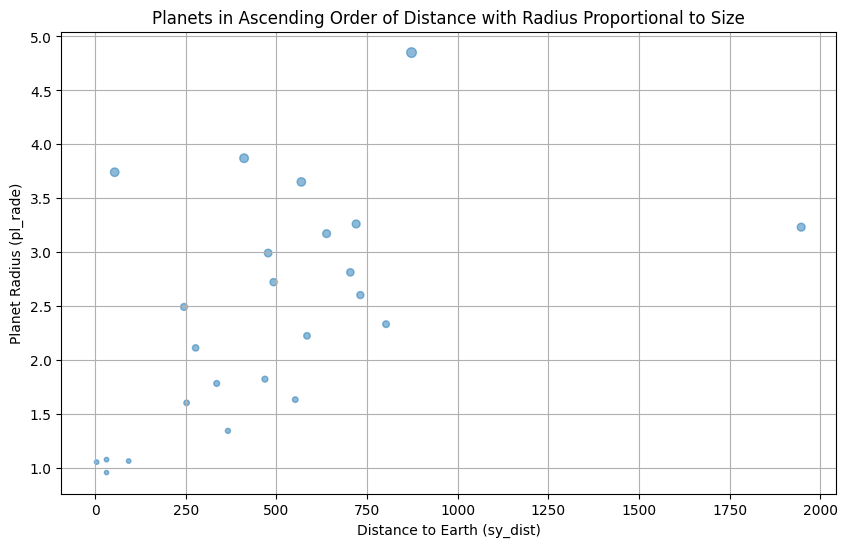

In [30]:
# It looks like we have a massive exoplanet with a mass of 1525 times Earth Mass
# With an astonishing gravitational acceleration, probably not human friendly
# So we will just remove it
#Conradium
outlier_tier = 1500

# Drop rows where "pl_bmasse" is greater than the threshold
df_true = df_true[df_true['pl_bmasse'] <= outlier_tier]


df_true_sorted = df_true.sort_values(by='sy_dist')

plt.figure(figsize=(10, 6))
plt.scatter(df_true_sorted['sy_dist'], df_true_sorted['pl_rade'], s=df_true_sorted['pl_rade']*10, alpha=0.5)
plt.xlabel('Distance to Earth (sy_dist)')
plt.ylabel('Planet Radius (pl_rade)')
plt.title('Planets in Ascending Order of Distance with Radius Proportional to Size')
plt.grid(True)

plt.show()

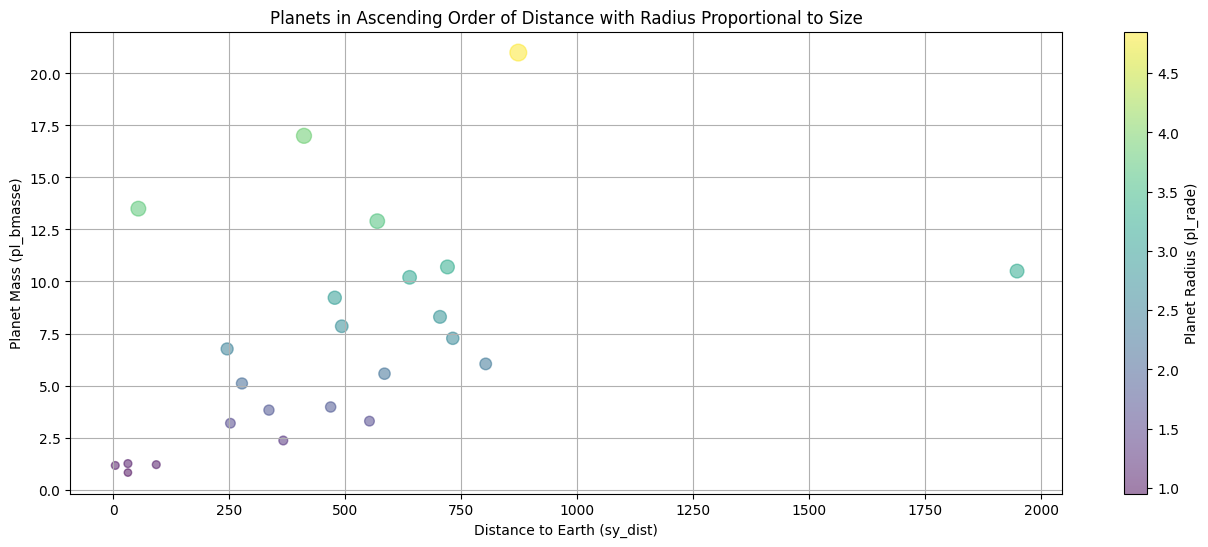

In [31]:
df_true_sorted = df_true.sort_values(by='sy_dist')

norm = plt.Normalize(df_true_sorted['pl_rade'].min(), df_true_sorted['pl_rade'].max())
cmap = plt.get_cmap('viridis')

plt.figure(figsize=(16, 6))
scatter = plt.scatter(
    df_true_sorted['sy_dist'],
    df_true_sorted['pl_bmasse'],
    s=df_true_sorted['pl_rade'] * 30,
    c=df_true_sorted['pl_rade'],
    cmap=cmap,
    norm=norm,
    alpha=0.5
)
#Conradium
plt.xlabel('Distance to Earth (sy_dist)')
plt.ylabel('Planet Mass (pl_bmasse)')
plt.title('Planets in Ascending Order of Distance with Radius Proportional to Size')
plt.grid(True)

cbar = plt.colorbar(scatter)
cbar.set_label('Planet Radius (pl_rade)')

plt.show()

<ipython-input-32-1f15674d1a3d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df_true_sorted['pl_name'], rotation=90)


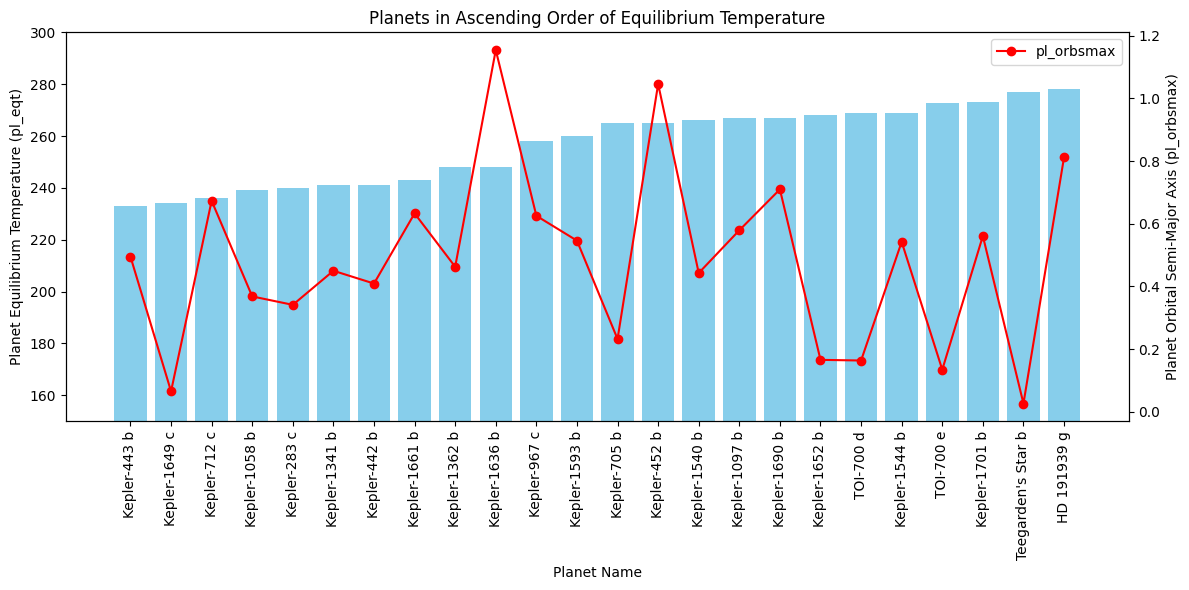

In [32]:
df_true_sorted = df_true.sort_values(by='pl_eqt')

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(df_true_sorted['pl_name'], df_true_sorted['pl_eqt'], color='skyblue')
ax1.set_xlabel('Planet Name')
ax1.set_ylabel('Planet Equilibrium Temperature (pl_eqt)')
ax1.set_title('Planets in Ascending Order of Equilibrium Temperature')
ax1.set_xticklabels(df_true_sorted['pl_name'], rotation=90)
ax1.set_ylim(150, 300)
ax2 = ax1.twinx()
ax2.plot(df_true_sorted['pl_name'], df_true_sorted['pl_orbsmax'], color='red', marker='o', label='pl_orbsmax')
ax2.set_ylabel('Planet Orbital Semi-Major Axis (pl_orbsmax)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

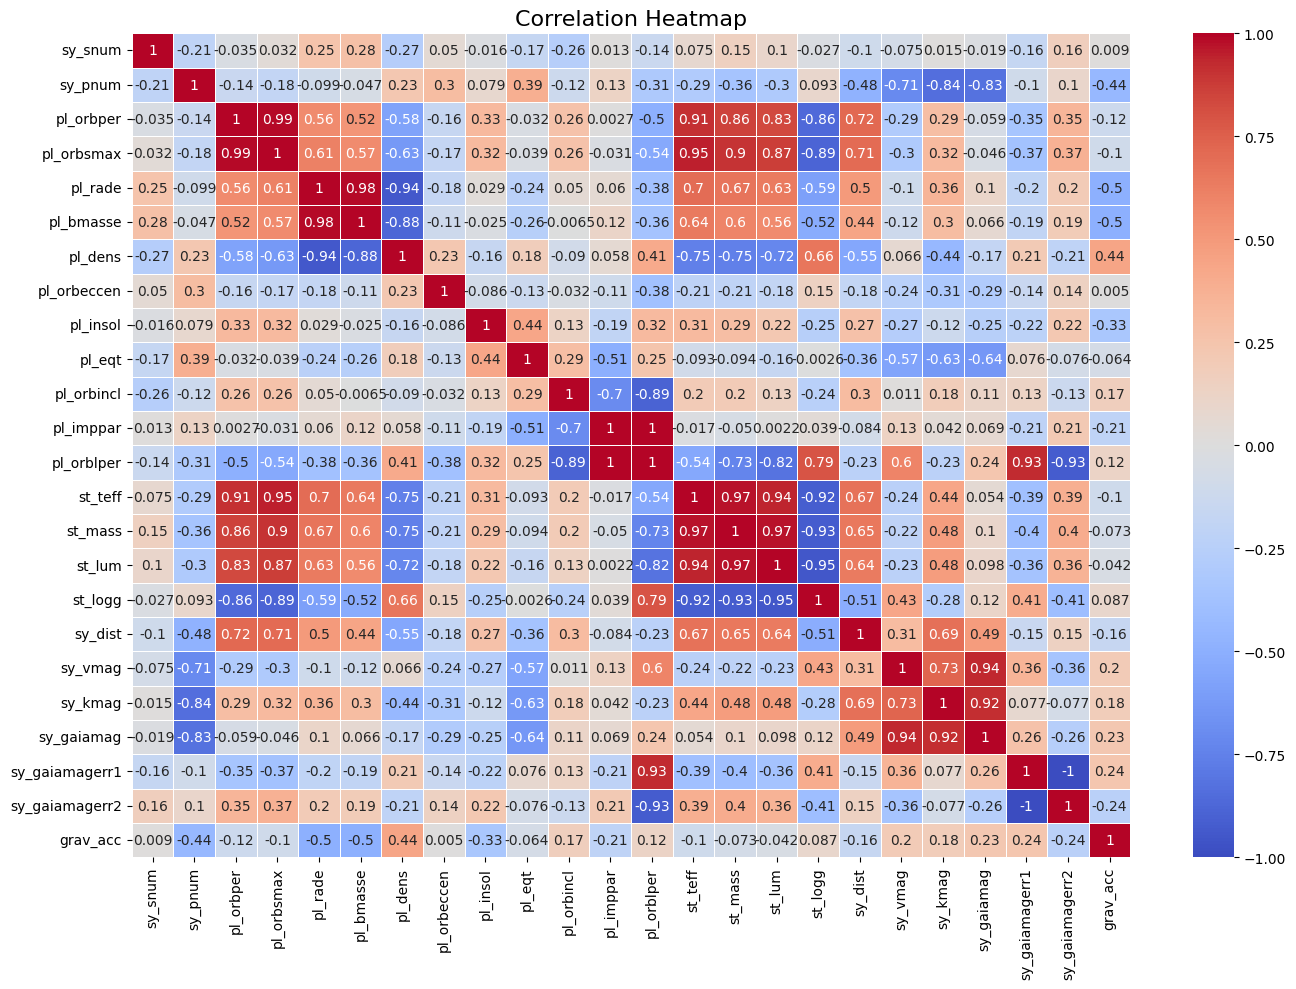

In [33]:
columns_to_correlate = ['sy_snum', 'sy_pnum', 'pl_orbper', 'pl_orbsmax', 'pl_rade',
                        'pl_bmasse', 'pl_dens', 'pl_orbeccen',
                        'pl_insol', 'pl_eqt', 'pl_orbincl', 'pl_imppar', 'pl_orblper',
                        'st_teff', 'st_mass', 'st_lum', 'st_logg',
                        'sy_dist', 'sy_vmag', 'sy_kmag',
                        'sy_gaiamag', 'sy_gaiamagerr1', 'sy_gaiamagerr2', 'grav_acc']

correlation_matrix = df_true[columns_to_correlate].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()

plt.show()

* pl_name: Exoplanet given name (Obviously not included, because it wasn't a quantible data)
* st_spectype: Host star stellar type (O, B, A, F, G, K, M).
* st_mass: Stellar Mass (Solar mass)
* st_teff: Stellar Effective Temperature - K.
* st_lum: Stellar Luminosity, measured in solar luminosities.
* sy_snum: Number of stars in the planetary system.
* sy_pnum: Number of planet in the planetary system.
* pl_bmasse (pl_mass): Mass of the exoplanet expressed in Earth masses, compared to Earth. (Earth = 1 Me, so 2Me = Earth mass*2).
* pl_rade: Radius of the explonaet express in Earth radius, compared to Earth. (Earth = 1 Re, so 2Re = Earth radius*2.
* pl_insol: Average stellar flux at surface express in Earth flux, compared to Earth. ( Earth = 1 Se, 2Se = Earth Se*2)
* pl_eqt: Exoplanet equilibrium temparature in Kelvins (K), estimated temparature since atmhospheres data uncertain (273.15 Kelvin = 0 Celsius).
* pl_orbeccen: Planet eccentricity, amount by which the orbit of the planet deviates from a perfect circle.
* pl_orbper: Orbital period, in days, to complete orbit around stellar host. (Earth = 365 days to complete orbit around Sun).
* sys_dist: planetary system distance from Earth in parsecs (pc). (1 pc = 3.26 light-years, or 206265 astronomical units, or 30.9 trillion kilometers)
* grav_acc: gravitational acceleration m/s2

In [34]:
x = df_true['pl_orbper']
y = df_true['pl_orbsmax']
st_mass = df_true['st_mass']

plotly_data = df_true[['pl_orbper', 'pl_orbsmax', 'st_mass']]
plotly_data['text'] = df_true['pl_name']

fig = px.scatter(
    plotly_data,
    x='pl_orbper',
    y='pl_orbsmax',
    color='st_mass',
    color_continuous_scale='viridis',
    text='text',
#Conradium
    labels={'pl_orbper': 'Orbital Period (days)',
            'pl_orbsmax': 'Orbit Semi-Major Axis (AU)'},
)

fig.update_coloraxes(colorbar_title='Stellar Mass (Solar Mass)')
fig.update_layout(
    title_text='Orbital Period vs. Orbit Semi-Major Axis (Color Gradient by Stellar Mass)',
    title_x=0.5,
)
fig.update_traces(textposition='top center',
                  showlegend=False,
                  textfont_size=2)

fig.update_traces(marker=dict(size=15))
fig.show()

<ipython-input-34-0d7d1530c131>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotly_data['text'] = df_true['pl_name']


In [35]:
radius = df_true['pl_rade']
mass = df_true['pl_bmasse']
density = df_true['pl_dens']

size_scaling_factor = 10
point_size = size_scaling_factor * radius

fig = px.scatter(
    df_true,
    x=radius,
    y=mass,
    color=density,
    color_continuous_scale='viridis',
    size=point_size,
    labels={'pl_rade': 'Planet Radius (Earth Radius)', 'pl_bmasse': 'Planet Mass (Earth Mass)'},
)

fig.update_coloraxes(colorbar_title='Planet Density (g/cm^3)')

fig.update_traces(text='', showlegend=False)

fig.update_layout(title_text='Planet Radius vs. Planet Mass vs. Planet Density (Gradient)', title_x=0.5)
fig.show()
#Conradium

In [36]:
fig = px.scatter(
    df_true,
    x='st_teff',
    y='pl_eqt',
    color='pl_orbsmax',
    color_continuous_scale='viridis',
    text='pl_name',
    labels={'st_teff': 'Stellar Effective Temperature (K)', 'pl_eqt': 'Equilibrium Temperature (K)'},
    title='Stellar Effective Temperature vs. Equilibrium Temperature (Color Gradient: pl_orbsmax)',
)

fig.update_coloraxes(colorbar_title='Orbit Semi-Major Axis (AU)')
fig.update_traces(marker=dict(size=10), textfont=dict(size=10))

fig.show()

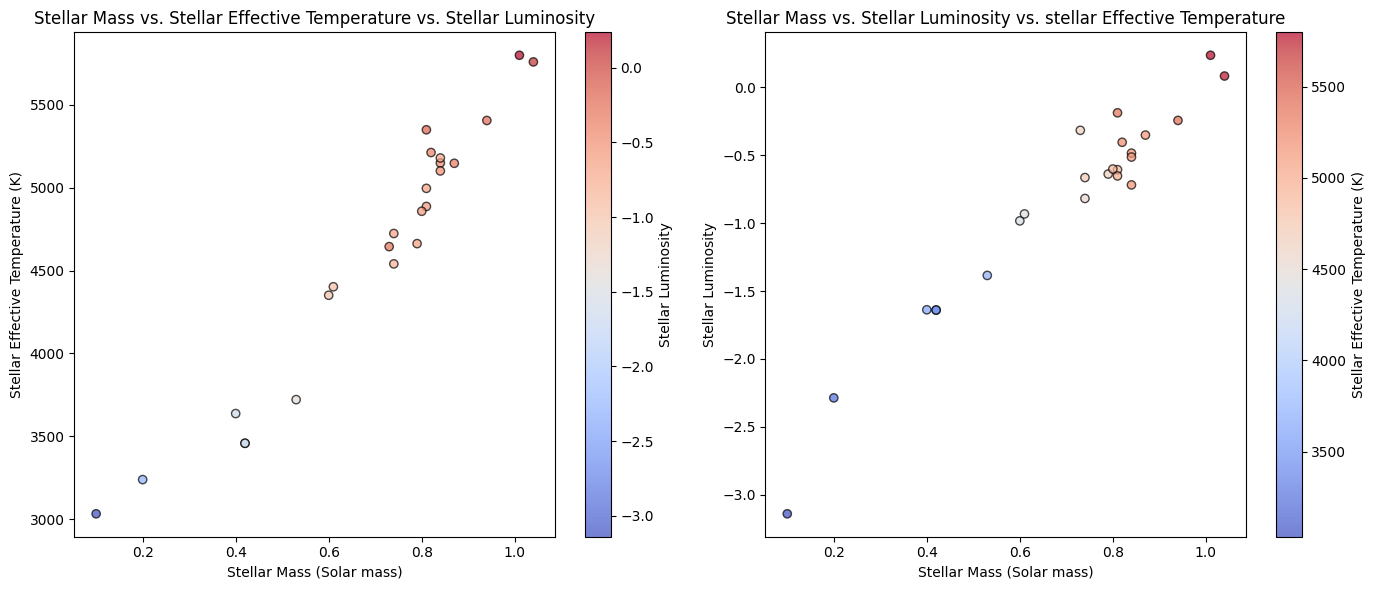

In [37]:
st_mass = df_true['st_mass']
st_teff = df_true['st_teff']
st_lum = df_true['st_lum']

colors = st_lum
cmap = plt.get_cmap('coolwarm')

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axs[0].scatter(st_mass, st_teff, c=colors, cmap=cmap, alpha=0.7, edgecolors='k')

cbar1 = fig.colorbar(scatter1, ax=axs[0])
cbar1.set_label('Stellar Luminosity')

axs[0].set_xlabel('Stellar Mass (Solar mass)')
axs[0].set_ylabel('Stellar Effective Temperature (K)') #fgjspaceman
axs[0].set_title('Stellar Mass vs. Stellar Effective Temperature vs. Stellar Luminosity')

scatter2 = axs[1].scatter(st_mass, st_lum, c=st_teff, cmap=cmap, alpha=0.7, edgecolors='k')

cbar2 = fig.colorbar(scatter2, ax=axs[1])
cbar2.set_label('Stellar Effective Temperature (K)')

axs[1].set_xlabel('Stellar Mass (Solar mass)')
axs[1].set_ylabel('Stellar Luminosity')
axs[1].set_title('Stellar Mass vs. Stellar Luminosity vs. stellar Effective Temperature')

plt.tight_layout()
plt.show()

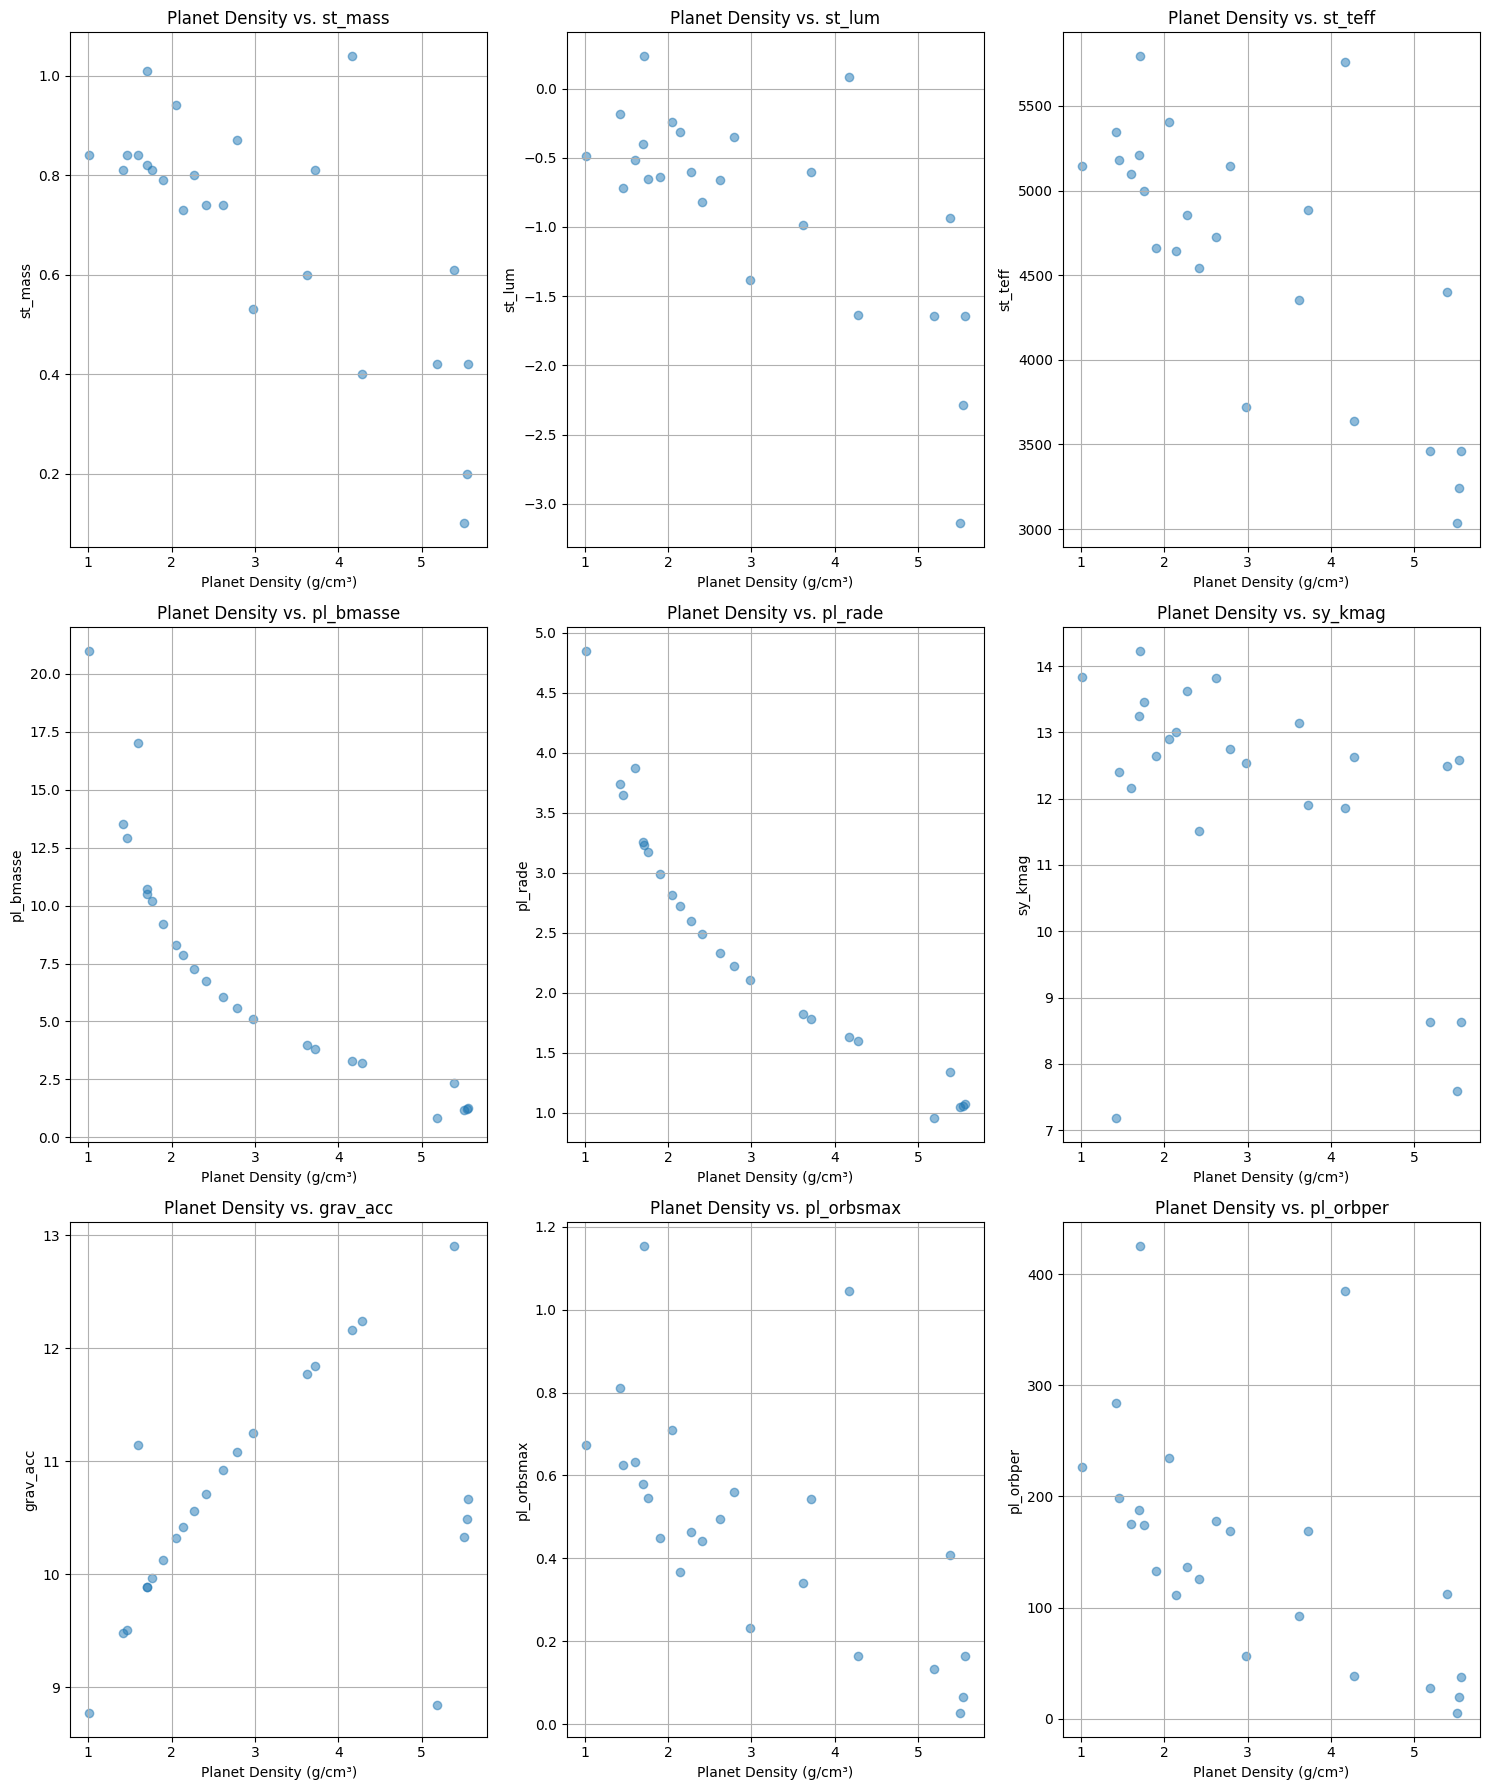

In [38]:
# Density Relationships

features = ['st_mass', 'st_lum', 'st_teff', 'pl_bmasse', 'pl_rade', 'sy_kmag', 'grav_acc', 'pl_orbsmax', 'pl_orbper']
num_features = len(features)
num_plots_per_line = 3

num_rows = (num_features + num_plots_per_line - 1) // num_plots_per_line
fig, axes = plt.subplots(num_rows, num_plots_per_line, figsize=(15, 6*num_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(df_true['pl_dens'], df_true[feature], alpha=0.5)
    ax.set_xlabel('Planet Density (g/cm³)')
    ax.set_ylabel(feature)
    ax.set_title(f'Planet Density vs. {feature}')
    ax.grid(True)

for i in range(num_features, num_rows * num_plots_per_line):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [39]:
# Here is our scoring module
# I am going to use Earth ratios and compare it to our exoplanets
# The idea is that the more similarities with Earth the better
# Which means the lower score, the less difference and so the better
# A higher score means more difference between pl_name X vs Earth

features = ['st_mass', 'st_lum', 'st_teff', 'pl_bmasse', 'pl_rade', 'grav_acc', 'pl_orbsmax', 'pl_orbper']

earth_values = {
    'st_mass': 1.0,      # Stellar mass in solar mass units
    'st_lum': 3.828,      # Stellar luminosity
    'st_teff': 5778,       # Stellar effective temperature in Kelvin
    'pl_bmasse': 1.0,      # Earth mass in Earth mass units
    'pl_rade': 1.0,      # Earth radius in Earth radius units
    'grav_acc': 9.80665,    # Earth gravitational acceleration
    'pl_orbsmax': 1.0,      # Earth orbit semi-major axis
    'pl_orbper': 365.25,   # Earth orbital period in days
}

scaler = StandardScaler()
df_true_normalized = scaler.fit_transform(df_true[features]) #fgjspaceman
earth_normalized = scaler.transform([list(earth_values.values())])

scores = []

for i, row in enumerate(df_true_normalized):
    differences = abs(row - earth_normalized)
    feature_scores = {feature: diff for feature, diff in zip(features, differences[0])}
    scores.append({'pl_name': df_true['pl_name'].iloc[i], 'hab_score_a': differences.sum(), **feature_scores})

score_df = pd.DataFrame(scores)
score_df = score_df.sort_values(by='hab_score_a', ascending=True)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [40]:
score_df.head(23)

,pl_name,hab_score_a,st_mass,st_lum,st_teff,pl_bmasse,pl_rade,grav_acc,pl_orbsmax,pl_orbper
3,Kepler-452 b,8.891065,0.169704,4.974692,0.026961,0.446825,0.619034,2.300504,0.165995,0.187352
20,Kepler-1636 b,10.091602,0.042426,4.771399,0.024393,1.853640,2.191182,0.074766,0.557886,0.575909
23,Kepler-1690 b,12.141158,0.254556,5.409180,0.480154,1.424376,1.779476,0.496892,1.047570,1.248954
9,HD 191939 g,13.601176,0.806093,5.334773,0.552049,2.439000,2.692305,0.321618,0.678413,0.776927
13,Kepler-1701 b,13.711451,0.551537,5.552681,0.811384,0.891698,1.200729,1.243239,1.584888,1.875295
0,Kepler-1097 b,14.522616,0.763667,5.623103,0.727934,1.892664,2.220660,0.078423,1.518851,1.697314
6,Kepler-1544 b,14.677458,0.806093,5.891502,1.145181,0.550238,0.766423,1.987271,1.652368,1.878382
8,Kepler-1593 b,15.310846,0.806093,5.952623,1.005243,1.795104,2.132227,0.157371,1.638295,1.823891
22,Kepler-443 b,15.425967,1.103075,5.968567,1.354446,0.983405,1.306849,1.093614,1.822332,1.793679
21,Kepler-1362 b,15.578019,0.848519,5.884859,1.182412,1.223402,1.572149,0.737267,1.939250,2.190162


In [41]:
# Renaming columns before merging them to df_true
columns_to_rename = {col: col + '_sa' for col in score_df.columns if col not in ['pl_name', 'hab_score_a']}
score_df = score_df.rename(columns=columns_to_rename)

In [42]:
score_df.head()

,pl_name,hab_score_a,st_mass_sa,st_lum_sa,st_teff_sa,pl_bmasse_sa,pl_rade_sa,grav_acc_sa,pl_orbsmax_sa,pl_orbper_sa
3,Kepler-452 b,8.891065,0.169704,4.974692,0.026961,0.446825,0.619034,2.300504,0.165995,0.187352
20,Kepler-1636 b,10.091602,0.042426,4.771399,0.024393,1.853640,2.191182,0.074766,0.557886,0.575909
23,Kepler-1690 b,12.141158,0.254556,5.409180,0.480154,1.424376,1.779476,0.496892,1.047570,1.248954
9,HD 191939 g,13.601176,0.806093,5.334773,0.552049,2.439000,2.692305,0.321618,0.678413,0.776927
13,Kepler-1701 b,13.711451,0.551537,5.552681,0.811384,0.891698,1.200729,1.243239,1.584888,1.875295


In [43]:
#actually, lets round up the values

columns_to_round = ['hab_score_a', 'st_mass_sa', 'st_lum_sa','st_teff_sa', 'pl_bmasse_sa',
                    'pl_rade_sa', 'grav_acc_sa', 'pl_orbsmax_sa', 'pl_orbper_sa']
score_df[columns_to_round] = score_df[columns_to_round].round(2) #2 sig fig is ok i guess

score_df.head(10)

,pl_name,hab_score_a,st_mass_sa,st_lum_sa,st_teff_sa,pl_bmasse_sa,pl_rade_sa,grav_acc_sa,pl_orbsmax_sa,pl_orbper_sa
3,Kepler-452 b,8.89,0.17,4.97,0.03,0.45,0.62,2.30,0.17,0.19
20,Kepler-1636 b,10.09,0.04,4.77,0.02,1.85,2.19,0.07,0.56,0.58
23,Kepler-1690 b,12.14,0.25,5.41,0.48,1.42,1.78,0.50,1.05,1.25
9,HD 191939 g,13.60,0.81,5.33,0.55,2.44,2.69,0.32,0.68,0.78
13,Kepler-1701 b,13.71,0.55,5.55,0.81,0.89,1.20,1.24,1.58,1.88
0,Kepler-1097 b,14.52,0.76,5.62,0.73,1.89,2.22,0.08,1.52,1.70
6,Kepler-1544 b,14.68,0.81,5.89,1.15,0.55,0.77,1.99,1.65,1.88
8,Kepler-1593 b,15.31,0.81,5.95,1.01,1.80,2.13,0.16,1.64,1.82
22,Kepler-443 b,15.43,1.10,5.97,1.35,0.98,1.31,1.09,1.82,1.79
21,Kepler-1362 b,15.58,0.85,5.88,1.18,1.22,1.57,0.74,1.94,2.19


In [44]:
# we add that score to our df_true for finalizing
df_true = df_true.merge(score_df, on='pl_name', how='left')

In [45]:
df_true.head()

,pl_name,hostname,sy_snum,sy_pnum,disc_facility,disc_telescope,pl_orbper,pl_orbsmax,pl_rade,pl_radj,...,true_count,hab_score_a,st_mass_sa,st_lum_sa,st_teff_sa,pl_bmasse_sa,pl_rade_sa,grav_acc_sa,pl_orbsmax_sa,pl_orbper_sa
0,Kepler-1097 b,Kepler-1097,1,1,Kepler,0.95 m Kepler Telescope,187.747029,0.5791,3.26,0.291,...,3,14.52,0.76,5.62,0.73,1.89,2.22,0.08,1.52,1.70
1,Teegarden's Star b,Teegarden's Star,1,3,Calar Alto Observatory,3.5 m telescope,4.906340,0.0259,1.05,0.094,...,5,24.16,3.82,9.26,3.52,0.03,0.05,0.51,3.52,3.45
2,Kepler-705 b,Kepler-705,1,1,Kepler,0.95 m Kepler Telescope,56.056054,0.2320,2.11,0.188,...,5,20.59,1.99,6.93,2.64,0.80,1.09,1.41,2.77,2.96
3,Kepler-452 b,Kepler-452,1,1,Kepler,0.95 m Kepler Telescope,384.843000,1.0460,1.63,0.145,...,5,8.89,0.17,4.97,0.03,0.45,0.62,2.30,0.17,0.19
4,Kepler-1649 c,Kepler-1649,1,2,Kepler,0.95 m Kepler Telescope,19.535270,0.0649,1.06,0.095,...,5,22.22,3.39,8.13,3.26,0.04,0.06,0.67,3.37,3.31


In [46]:
#correlation between st_teff_sa and the hab_score_a
correlation_score = df_true['st_teff_sa'].corr(df_true['hab_score_a'])
print(f"Correlation between st_teff_sa and hab_score_a: {correlation_score}")


Correlation between st_teff_sa and hab_score_a: 0.9168613447878021


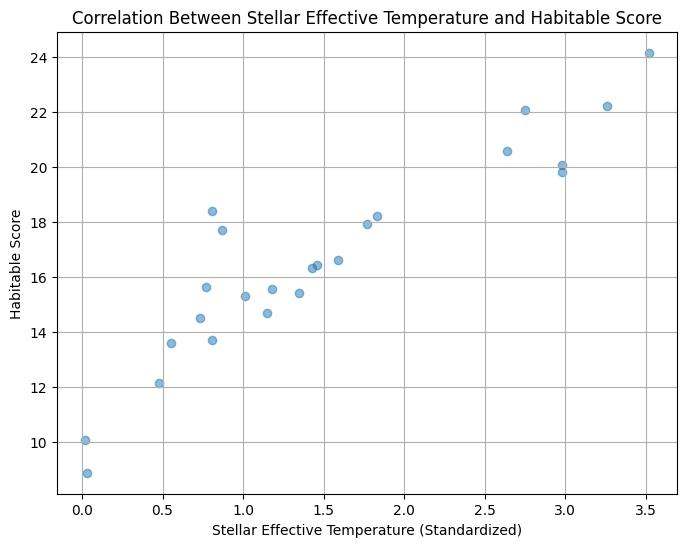

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(df_true['st_teff_sa'], df_true['hab_score_a'], alpha=0.5)
plt.xlabel('Stellar Effective Temperature (Standardized)')
plt.ylabel('Habitable Score')
plt.title('Correlation Between Stellar Effective Temperature and Habitable Score')
plt.grid(True)
plt.show()
 #A higher score means more difference between pl_name X vs Earth

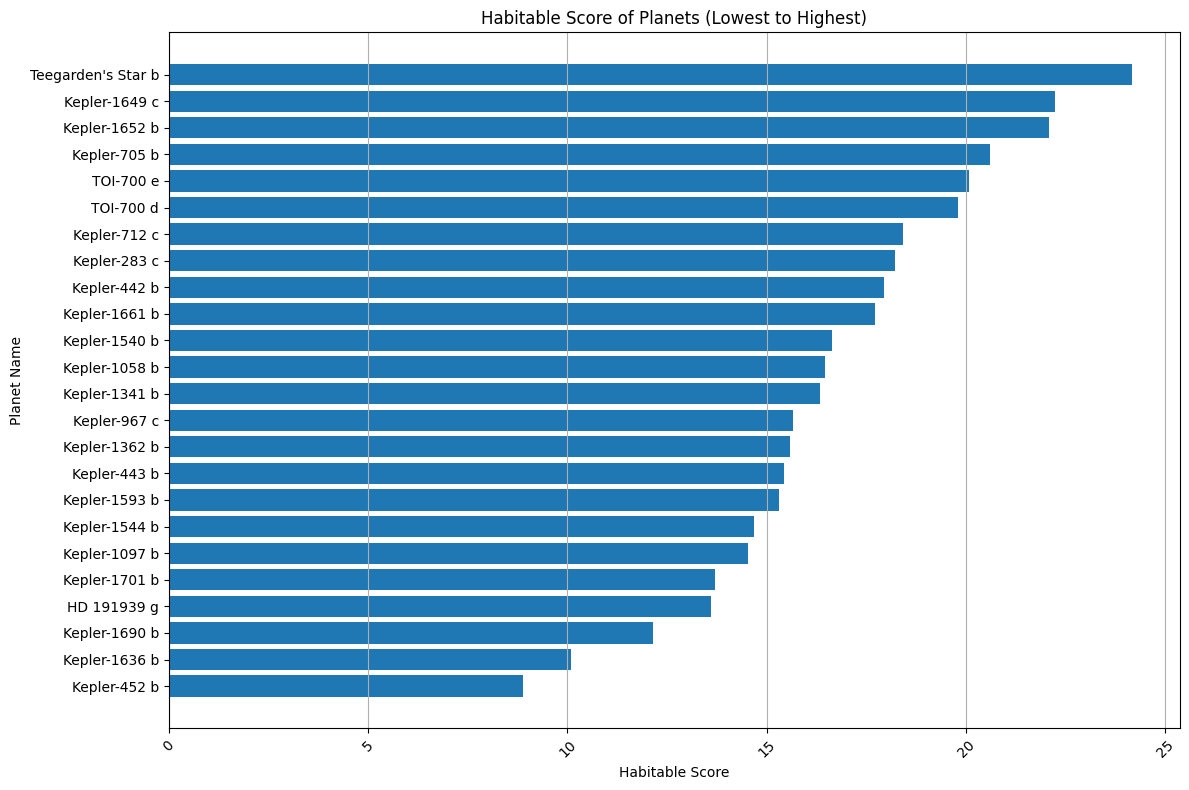

In [48]:
# prompt: use the entire df_true dataframe, show the names of the planet, with the lowest habitable score to the highest. Graph it

import matplotlib.pyplot as plt

# Sort df_true by hab_score_a in ascending order
df_true_sorted = df_true.sort_values('hab_score_a')

# Get the planet names and hab_score_a values
planet_names = df_true_sorted['pl_name'].tolist()
hab_scores = df_true_sorted['hab_score_a'].tolist()

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(planet_names, hab_scores)
plt.xlabel('Habitable Score')
plt.ylabel('Planet Name')
plt.title('Habitable Score of Planets (Lowest to Highest)')
plt.grid(True, axis='x')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [49]:
# Filter the dataframe to get the row for Kepler-452b
kepler_452b_data = df_true[df_true['pl_name'] == 'Kepler-452 b']

# Print all columns and their values
print("Planet Information:")
for key, value in kepler_452b_data.to_dict('records')[0].items():
    if key == 'pl_name':
        print(f"Planet Name: {value}")
    elif key == 'hostname':
        print(f"Host Star: {value}")
    elif key == 'sy_snum':
        print(f"Number of Stars in System: {value}")
    elif key == 'sy_pnum':
        print(f"Number of Planets in System: {value}")
    elif key == 'disc_facility':
        print(f"Discovery Facility: {value}")
    elif key == 'disc_telescope':
        print(f"Discovery Telescope: {value}")
    elif key == 'pl_orbper':
        print(f"Orbital Period (days): {value}")
    elif key == 'pl_orbsmax':
        print(f"Orbit Semi-Major Axis (au): {value}")
    elif key == 'pl_bmasse':
        print(f"Planet Mass (Earth Masses): {value}")
    elif key == 'pl_bmassprov':
        print(f"Planet Mass Provenance: {value}")
    elif key == 'pl_dens':
        print(f"Planet Density (g/cm^3): {value}")
    elif key == 'pl_orbeccen':
        print(f"Eccentricity: {value}")
    elif key == 'pl_insol':
        print(f"Insolation Flux (Earth Flux): {value}")
    elif key == 'pl_eqt':
        print(f"Equilibrium Temperature (K): {value}")
    elif key == 'pl_orbincl':
        print(f"Inclination (deg): {value}")
    elif key == 'ttv_flag':
        print(f"Transit Timing Variations: {value}")
    elif key == 'pl_imppar':
        print(f"Impact Parameter: {value}")
    elif key == 'pl_orblper':
        print(f"Argument of Periastron (deg): {value}")
    elif key == 'st_spectype':
        print(f"Stellar Spectral Type: {value}")
    elif key == 'st_logg':
        print(f"Stellar Surface Gravity (log10(cm/s^2)): {value}")
    elif key == 'rastr':
        print(f"Right Ascension (sexagesimal): {value}")
    elif key == 'ra':
        print(f"Right Ascension (deg): {value}")
    elif key == 'decstr':
        print(f"Declination (sexagesimal): {value}")
    elif key == 'dec':
        print(f"Declination (deg): {value}")
    elif key == 'sy_dist':
        print(f"Distance (pc): {value}")
    elif key == 'sy_vmag':
        print(f"V (Johnson) Magnitude: {value}")
    elif key == 'sy_kmag':
        print(f"Ks (2MASS) Magnitude: {value}")
    elif key == 'sy_gaiamag':
        print(f"Gaia Magnitude: {value}")
    elif key == 'apoapsis_AU':
        print(f"Apoapsis (AU): {value}")
    elif key == 'periapsis_AU':
        print(f"Periapsis (AU): {value}")
    elif key == 'hab_score_a':
        print(f"Habitable Score: {value}")
    elif key == 'st_mass_sa':
        print(f"Stellar Mass Uncertainty (Solar Masses): {value}")
    elif key == 'st_lum_sa':
        print(f"Stellar Luminosity Uncertainty (log(Solar)): {value}")
    elif key == 'st_teff_sa':
        print(f"Stellar Effective Temperature Uncertainty (K): {value}")
    elif key == 'pl_bmasse_sa':
        print(f"Planet Mass or Mass*sin(i) Uncertainty (Earth Masses): {value}")
    elif key == 'pl_rade_sa':
        print(f"Planet Radius Uncertainty (Earth Radii): {value}")
    elif key == 'grav_acc_sa':
        print(f"Surface Gravity Uncertainty (m/s^2): {value}")
    elif key == 'pl_orbsmax_sa':
        print(f"Orbit Semi-Major Axis Uncertainty (au): {value}")
    elif key == 'pl_orbper_sa':
        print(f"Orbital Period Uncertainty (days): {value}")
    elif key == 'hab_rank':
        print(f"Habitable Rank: {value}")

Planet Information:
Planet Name: Kepler-452 b
Host Star: Kepler-452
Number of Stars in System: 1
Number of Planets in System: 1
Discovery Facility: Kepler
Discovery Telescope: 0.95 m Kepler Telescope
Orbital Period (days): 384.843
Orbit Semi-Major Axis (au): 1.046
Planet Mass (Earth Masses): 3.29
Planet Mass Provenance: M-R relationship
Planet Density (g/cm^3): 4.17
Eccentricity: 0.0
Insolation Flux (Earth Flux): 1.1
Equilibrium Temperature (K): 265.0
Inclination (deg): 89.806
Transit Timing Variations: 0
Impact Parameter: 0.69
Argument of Periastron (deg): nan
Stellar Spectral Type: G2
Stellar Surface Gravity (log10(cm/s^2)): 4.32
Right Ascension (sexagesimal): 19h44m00.90s
Right Ascension (deg): 296.003752
Declination (sexagesimal): +44d16m39.31s
Declination (deg): 44.2775861
Distance (pc): 551.727
V (Johnson) Magnitude: 13.54
Ks (2MASS) Magnitude: 11.852
Gaia Magnitude: 13.4048
Apoapsis (AU): 1.046
Periapsis (AU): 1.046
Habitable Score: 8.89
Stellar Mass Uncertainty (Solar Masses): 